이번에는 합성곱 층의 가중치와 특성 맵을 그림으로 시각화해보자. 먼저 2절에서 훈련했던 합성곱 신경망을 가져오도록하자. 아래는 2절에서 만든 합성곱 신경망의 코드이다. 

훈련결과는 매번 달라지므로 이전의 결과와는 다르다.

In [2]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size = 0.2, random_state = 42)
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size = 3, activation = 'relu', padding = 'same', input_shape = (28, 28, 1)))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Conv2D(64, kernel_size = 3, activation = 'relu', padding = 'same'))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation = 'relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation = 'softmax'))
model.compile(optimizer = 'adam',loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5', save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 2, restore_best_weights = True)
history = model.fit(train_scaled, train_target, epochs = 20, validation_data = (val_scaled, val_target), callbacks = [checkpoint_cb, early_stopping_cb])

4431872/4422102 [==============================] - 0s 0us/step
Epoch 1/20
1500/1500 [==============================] - 64s 42ms/step - loss: 0.5339 - accuracy: 0.8073 - val_loss: 0.3436 - val_accuracy: 0.8712
Epoch 2/20
1500/1500 [==============================] - 63s 42ms/step - loss: 0.3545 - accuracy: 0.8720 - val_loss: 0.2950 - val_accuracy: 0.8867
Epoch 3/20
1500/1500 [==============================] - 63s 42ms/step - loss: 0.3068 - accuracy: 0.8892 - val_loss: 0.2606 - val_accuracy: 0.9025
Epoch 4/20
1500/1500 [==============================] - 62s 42ms/step - loss: 0.2723 - accuracy: 0.9004 - val_loss: 0.2437 - val_accuracy: 0.9071
Epoch 5/20
1500/1500 [==============================] - 62s 41ms/step - loss: 0.2499 - accuracy: 0.9090 - val_loss: 0.2392 - val_accuracy: 0.9122
Epoch 6/20
1500/1500 [==============================] - 62s 41ms/step - loss: 0.2299 - accuracy: 0.9154 - val_loss: 0.2272 - val_accuracy: 0.9165
Epoch 7/20
1500/1500 [==============================] - 62s 4

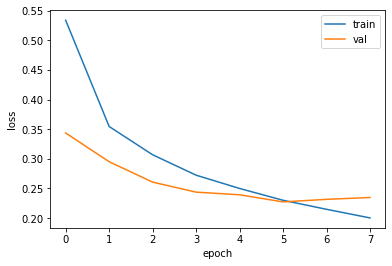

In [3]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

합성곱 층은 **여러 개의 필터를 사용해 이미지에서 특징을 학습**한다. 각 필터는 커널이라고 불리는 가중치와 절편들 가진다. 일반적으로 절편을 시각적으로 의미가 없으며 **가중치는 입력 이미지의 2차원 영역에 적용되어 어떤 특징을 두드러지게 표현하는 역할을 한다**.

2절에서 만든 모델이 어떤 가중치를 학습했는지 확인하기 위해 체크포인트 파일을 불러보자.

In [4]:
from tensorflow import keras
model = keras.models.load_model('best-cnn-model.h5')

케라스 모델에 추가한 층은 **layers 속성**에 저장되어있다. 이 속성은 **파이썬 리스트**이다.

In [5]:
model.layers

model.layers 리스트에 이전 절에서 추가했던 합성곱-풀링 층 2개와 Flatten 층, 은닉층, dropout 층, 출력층 모두 포함되어있다.

첫 번째 합성곱 층의 가중치를 조사해보자. 층의 가중치와 절편은 층의 **weights 속성**에 저장된다. weights 속성 역시 파이썬 리스트이다. 이때 weights의 첫 번째 원소(가중치)와 두 번째 원소(절편)의 크기를 출력해보자.

In [34]:
type(conv.weights)

list

In [6]:
conv = model.layers[0]
print(conv.weights[0].shape, conv.weights[1].shape)

(3, 3, 1, 32) (32,)


우리가 만든 커널의 크기는 (3, 3)이었다. 또한 깊이는 1이므로 커널의 실제 크기는 (3, 3, 1)이 된다. 이때 필터의 개수가 32개 이므로 총 가중치의 크기는 (3, 3, 1, 32)가 된다. 절편은 필터마다 1개이므로 (32, )의 크기를 가진다.

weights 속성은 텐서플로의 다차원 배열인 **Tensor 클래스의 객체**이다. 다루기 쉽도록 numpy() 배열로 변환하고 가중치 배열의 평균과 표준편차를 구해보자.

In [36]:
type(conv.weights[0])

tensorflow.python.ops.resource_variable_ops.ResourceVariable

In [35]:
conv_weights = conv.weights[0].numpy()
print(type(conv_weights))
print(conv_weights.mean(), conv_weights.std())

<class 'numpy.ndarray'>
-0.023927586 0.24786133


이 가중치의 평균값은 0에 가깝고 표준편차는 0.27 정도이다. 나중에 이 값을 훈련하기 전의 가중치와 비교해보자. 이 가중치가 어떤 분포를 가졌는지 히스토그램을 그려보자.

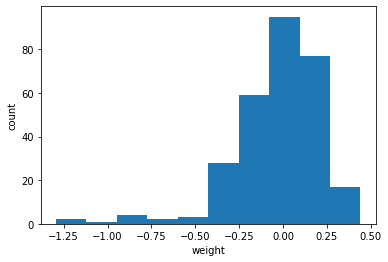

In [8]:
import matplotlib.pyplot as plt
plt.hist(conv_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

맷플롯립의 hist() 함수에는 히스토그램을 그리기 위해 1차원 배열로 전달해야한다. 따라서 reshape() 메서드로 1차원 배열로 변환했다.

히스토그램을 보면 0을 중심으로 종 모양 분포를 띠는 것을 알 수 있다. 이 가중치가 무엇을 의미하는 지는 이후 훈련하기 전의 가중치와 비교해보록 하자. 

이번에는 커널을 출력해보자.

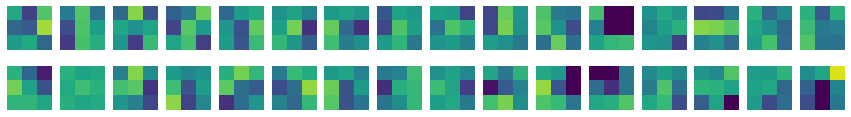

In [12]:
fig, axs = plt.subplots(2, 16, figsize = (15, 2))
for i in range(2):
  for j in range(16):
    axs[i, j].imshow(conv_weights[:, :, 0, i * 16 + j], vmin = -0.5, vmax = 0.5)
    axs[i, j].axis('off')
plt.show()

**imshow() 함수는 배열에 있는 최댓값과 최솟값을 사용해 픽셀의 강도를 표현한다.** 즉, 0.1 이나 0.4나 그 배열의 최댓값이면 가장 밝은 노란 색으로 그린다. 하지만 두 배열을 imshow() 함수로 비교하려면 이런 동작은 바람직하지 않다. 더떤 절댓값을 기준으로 정해서 픽셀의 강도를 나타내야 비교하기 좋다. 따라서 **vmin**과 **vmax**로 이를 지정해 표현할 범위를 지정했다.

결과를 보면 **가중치 값이 무작위로 나열된 것이 아니라 어떤 패턴을 볼 수 있다**. 예를 들어 첫 번째 열의 2번째 이미지는 중앙의 3픽셀의 값이 높다(밝은 부분의 값이 높다). 이 가중치는 중앙에 놓인 직선을 만나면 크게 활성화될 것이다.

이번에는 훈련하지 않는 빈 합성곱 신경망을 만들어보자.

In [13]:
no_training_model = keras.Sequential()
no_training_model.add(keras.layers.Conv2D(32, kernel_size = (3, 3), activation = 'relu', padding = 'same', input_shape = (28, 28, 1)))

그 다음 이 모델의 첫 번째 층의 가중치를 no_training_conv 변수에 저장하자.

In [14]:
no_training_conv = no_training_model.layers[0]
print(no_training_conv.weights[0].shape)

(3, 3, 1, 32)


이 가중치의 크기도 앞서 그래프로 출력한 가중치와 같다. 동일하게 (3, 3) 커널을 가진 필터 32개를 사용했기 때문이다. 이전처럼 넘파이 배열로 변환후 평균과 표준편차를 구해보자.

In [15]:
no_training_weights = no_training_conv.weights[0].numpy()
print(no_training_weights.mean(), no_training_weights.std())

-0.0054466045 0.081851


평균은 이전과 동일하게 0에 가깝지만 표준편차는 매우 작아졌다. 이 가중치 배열을 히스토그램으로 그려보자.

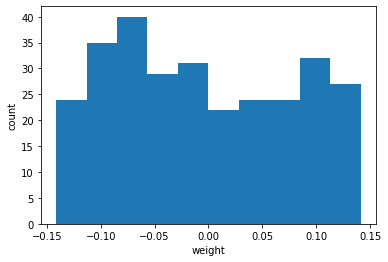

In [16]:
plt.hist(no_training_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

대부분의 가중치가 -0.15 ~ 0.15 사이에 있고 비교적 고른 분포를 보인다. 이는 텐서플로가 신경망의 가중치를 처음 초기화할 때 **균등 분포에서 랜덤하게 값을 선택**하기 때문이다.

이 가중치 값을 이전처럼 그림으로 출력해보자.

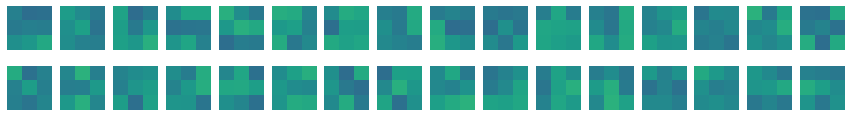

In [18]:
fig, axs = plt.subplots(2, 16, figsize = (15, 2))
for i in range(2):
  for j in range(16):
    axs[i, j].imshow(no_training_weights[:, :, 0, i * 16 + j], vmin = -0.5, vmax = 0.5)
    axs[i, j].axis('off')
plt.show()

전체적으로 가중치가 밋밋하게 초기화되었다. 합성곱 신경망이 패션 MNIST 데이터셋의 분류 정확도를 높이기 위해 유용한 패턴을 학습했다는 것을 알 수 있다.

합성곱 신경망의 학습을 시각화하는 두 번째 방법은 특성 맵을 그려보는 것이다. 그전에 케라스 함수형 API에 대해 알아보자.

지금까지 신경망 모델을 만들 때 케라스 Sequential 클래스를 사용했다. 이 클래스는 층을 차례대로 쌓은 모델을 만든다. 하지만 딥러닝에는 좀 더 복잡한 모델이 많이 있다. 예를 들어, 입력이 2개일 수도 있고 출력이 2개 일수도 있다. 이런 경우에 Sequential 클래스를 사용하기 어렵다. 대신 **'함수형 API(functional API)'**를 사용한다.

함수형 API는 케라스 Model 클래스를 사용해 모델을 만든다. 7장에서 만들었던 Dense 층 2개로 이루어진 완전 연결 신경망을 함수형 API로 구현해보자. 먼저 2개의 Dense층 객체를 만든다.

* dense1 = keras.layers.Dense(100, activation = 'sigmoid')
* dense2 = keras.layers.Dense(10, activation = 'softmax')

이전에는 이 객체를 Sequential 클래스 객체의 add() 메서드에 전달했었다. 하지만 다음과 같이 **함수처럼 호출**할 수도 있다.

* hidden = dense1(inputs)

케라스의 층은 객체를 함수처럼 호출했을 때 적절히 동작할 수 있도록 미리 구현되어 있다. 앞의 코드를 실행하면 **입력값 inputs를 Dense 층에 통과시켜 출력값 hidden을 만들어준다**.

그 다음 두번째 층을 호출해보자. 이때는 첫 번째 층의 출력을 입력으로 사용한다.

* outputs = dense2(hidden)

그 다음 **inputs와 outputs를 Model 클래스로 연결**해주면 된다.

* model = keras.Model(inputs, outputs)

정리해보면 입력에서 출력까지 층을 호출한 결과를 계속 이어주고 Model 클래스에 입력과 최종 출력을 지정한다. 그런데 inputs는 어디서 나온걸까? 이전에 Sequential 클래스 객체를 도식화했을때 **InputLayer 클래스**를 본적이있다. 이 InputLayer 클래스가 inputs가 되어야하며 Sequential 클래스는 이를 자동으로 추가하고 호출해줬지만 Model 클래스에서는 우리가 수동으로 만들어야한다.

* 케라스 모델은 layers 속성 외에 InputLayer 객체를 포함한 **_layers 리스트 속성**을 따로 가지고 있다. **Sequential 클래스 객체의 _layers 속성의 첫 번째 항목**이 InputLayer 클래스의 객체이다.

케라스는 InputLayer 클래스 객체를 쉽게 다룰 수 있도록 **Input() 함수**를 별도로 제공한다. 입력의 크기를 지정하는 **shape 매개변수**와 함께 함수를 호출하면 InputLayer 클래스 객체를 만들어 반환해준다.

* inputs = keras.Input(shape = (784, ))

이렇게 모델을 만들게 되면 중간에 다양한 형태로 층을 연결할 수 있다.


그런데 특성 맵 시각화를 하는데 왜 함수형 API가 필요할까?

우리가 필요한 것은 첫 번째 Conv2D의 출력이다. 즉, model 객체의 입력과 Conv2D의 출력을 알 수 있으면 이 둘을연결하여 새로운 모델을 얻을 수 있다.

model 객체의 predict() 메서드를 사용하면 입력부터 마지막 층까지 모든 계산을 수행한 후 최종 출력을 반환한다. 하지만 우리가 필요한 것은 첫 번째 Conv2D 층이 출력한 특성 맵이다. 첫 번째 Conv2D의 출력은 Conv2D 객체의 **output 속성**에서 얻을 수 있다.

* **model.layers[0].output**

model 객체의 입력을 어떻게 얻을 수 있을까? 케라스 모델은 **input 속성**으로 입력을 찹조할 수 있다. 즉 model.input으로 모델의 입력을 얻을 수 있다.

In [24]:
print(model.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='conv2d_input'), name='conv2d_input', description="created by layer 'conv2d_input'")


이제 model.input과 model.layers[0].output을 연결하는 새로운 모델을 만들 수 있다.

In [23]:
conv_acti = keras.Model(model.input, model.layers[0].output)

이 모델의 predict() 메서드를 호출하면 첫 번째 Conv2D의 출력이 반환된다. 이제 특성 맵을 시각화해보자.

케라스로 패션 MNIST 데이터셋을 읽고 훈련 세트에 있는 첫 번째 샘플을 그려보자.

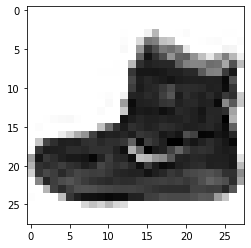

In [25]:
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
plt.imshow(train_input[0], cmap = 'gray_r')
plt.show()

이 샘플을 conv_acti 모델에 주입하여 Conv2D 층이 만드는 특성 맵을 출력해보자. **predict() 메서드는 입력의 첫 번째 차원을 배치 차원으로 기대**하므로 슬라이싱 연산자로 첫 번째 샘플을 선택하자. 이외의 과정은 2절의 과정과 동일하다.

In [26]:
inputs = train_input[0:1].reshape(-1, 28, 28, 1) / 255.0
feature_maps = conv_acti.predict(inputs)

feature_maps의 크기를 확인해 보자.

In [27]:
print(feature_maps.shape)

(1, 28, 28, 32)


세임 패딩과 32개의 필터를 사용한 합성곱 층의 출력이므로 (28, 28, 32)의 크기를 가진다. 첫 번째 차원은 배치 차원이므로 1이다.

이제 이 특성 맵을 그려보자.

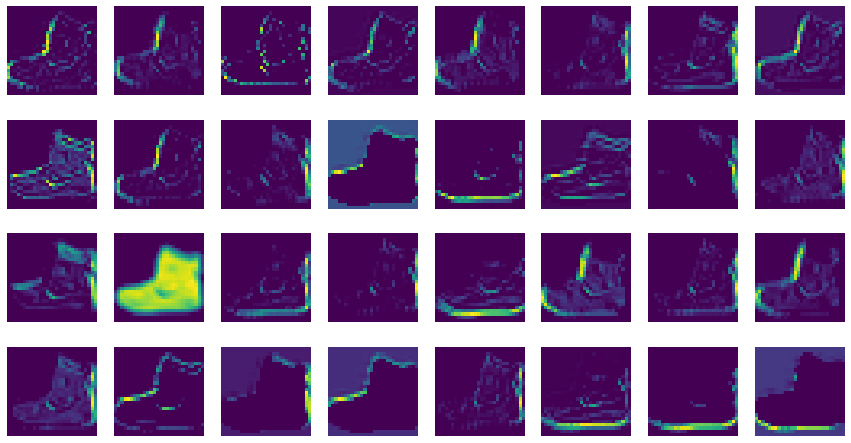

In [29]:
fig, axs = plt.subplots(4, 8, figsize = (15, 8))
for i in range(4):
  for j in range(8):
    axs[i, j].imshow(feature_maps[0, :, :, i * 8 + j])
    axs[i, j].axis('off')
plt.show()

이 특성 맵은 **32개의 필터로 입력 이미지에서 강하게 활성화된 부분을 보여준다**. 앞서 32개 필터의 가중치를 출력한 그림과 몇 개를 비교해보면 확인할 수 있다. (책 참고)

두 번째 합성곱 층의 특성 맵도 같은 방식으로 확인할 수 있다. model.input과 model.layers[2].output을 Model로 연결해주면 된다.

In [30]:
conv2_acti = keras.Model(model.input, model.layers[2].output)

첫 번째 샘플을 predict() 메서드에 전달하자.

In [31]:
inputs = train_input[0:1].reshape(-1, 28, 28, 1) / 255.0
feature_maps = conv2_acti.predict(inputs)

첫 번째 풀링 층에서 가로세로 길이가 절반으로 줄었다. 따라서 크기를 확인하면 (14, 14, 64)가 될 것이다.

In [32]:
print(feature_maps.shape)

(1, 14, 14, 64)


특성 맵을 그려보자.

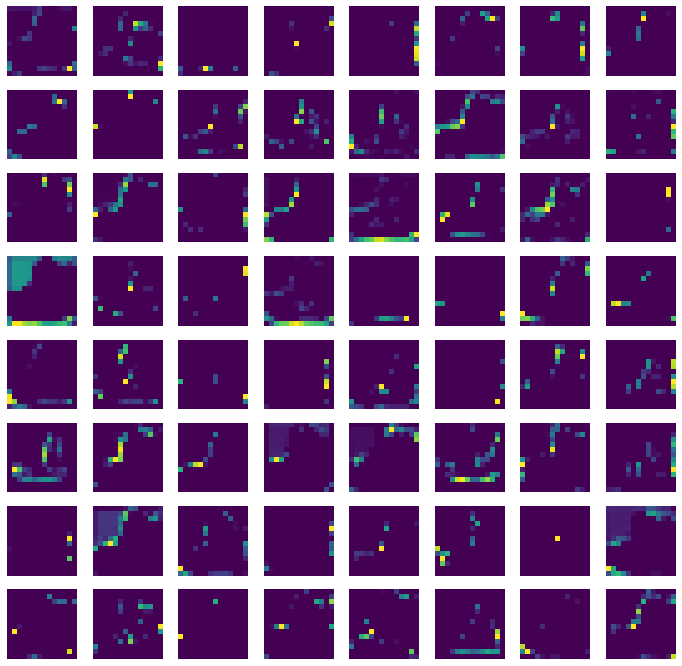

In [33]:
fig, axs = plt.subplots(8, 8, figsize = (12, 12))
for i in range(8):
  for j in range(8):
    axs[i, j].imshow(feature_maps[0, :, :, i * 8 + j])
    axs[i, j].axis('off')
plt.show()

이 특성 맵은 시각적으로 이해하기 어렵다. 왜 이런 결과가 나올까?

두 번째 합성곱의 필터 크기는 (3, 3, 32)이다. 두 번째 합성곱 층의 첫 번째 필터가 앞서 출력한 32개의 특성 맵과 곱해져 두 번째 합성곱 층의 첫 번째 특성 맵이 된다. 따라서 이렇게 계산된 출력은 (14, 14, 32) 특성 맵에서 어떤 부위를 감지하는지 직관적으로 이해하기 어렵다. 이런 현상은 합성곱 층을 많이 쌓을수록 심해진다. 이를 바꾸어 생각하면 **첫 번째 합성곱 층은 이미지의 시각적인 정보를 감지**하고 뒤쪽에 있는 합성곱 층은 앞쪽에서 감지한 시각적인 정보를 바탕으로 **추상적인 정보를 학습**한다고 볼 수 있다.

두 번째 셈플로도 한 동일한 과정을 실습해보았다.

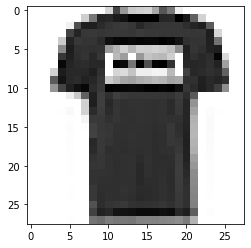

In [37]:
plt.imshow(train_input[1], cmap = 'gray_r')
plt.show()

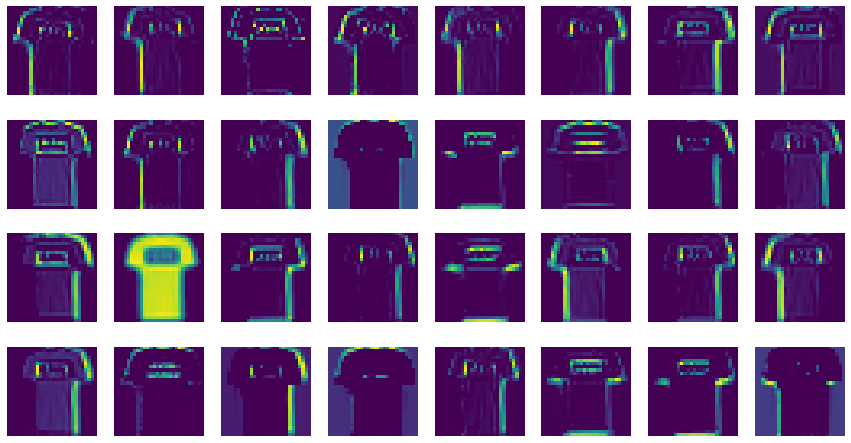

In [41]:
inputs = train_input[1:2].reshape(-1, 28, 28, 1) / 255.0
feature_maps = conv_acti.predict(inputs)

# 특성 맵 출력
fig, axs = plt.subplots(4, 8, figsize = (15, 8))
for i in range(4):
  for j in range(8):
    axs[i, j].imshow(feature_maps[0, :, :, i * 8 + j])
    axs[i, j].axis('off')
plt.show()

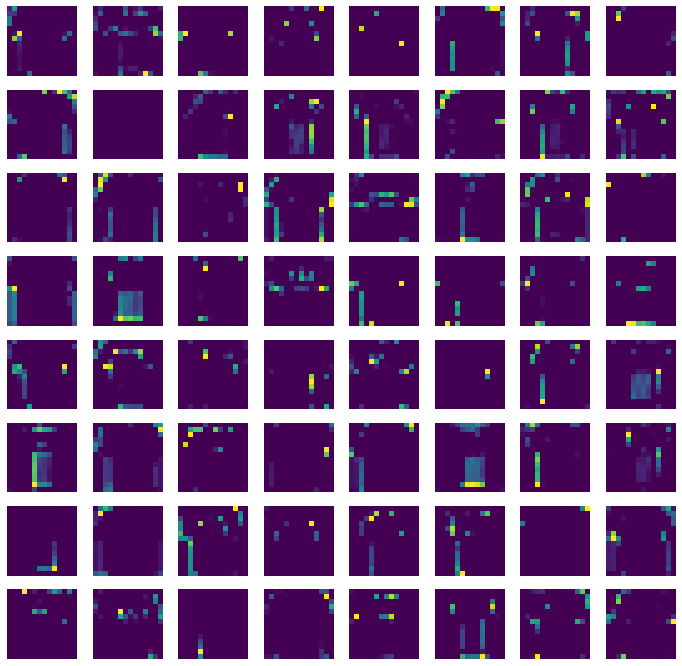

In [42]:
feature_maps = conv2_acti.predict(inputs)

# 특성 맵 출력
fig, axs = plt.subplots(8, 8, figsize = (12, 12))
for i in range(8):
  for j in range(8):
    axs[i, j].imshow(feature_maps[0, :, :, i * 8 + j])
    axs[i, j].axis('off')
plt.show()

# 정리

핵심 포인트
* 가중치 시각화: **합성곱 층의 가중치를 이미지로 출력하는 것을 말한다.** 합성곱 신경망은 주로 이미지를 다루기 때문에 가중치가 시각적인 패턴을 학습하는지 알아볼 수 있다.
* 특성 맵 시각화: **합성곱 층의 확성화 출력을 이미지로 그리는 것을 말한다.** 가중치 시각화와 함께 비교하여 각 필터가 이미지의 어느 부분을 활성화시키는지 확인할 수 있다.
* 함수형 API: **케라스에서 신경망 모델을 만드는 방법** 중 하나이다. Model 클래스에 모델의 입력과 출력을 지정한다. 전형적으로 입력은 Input() 함수를 사용하여 정의하고 출력은 마지막 층의 출력으로 정의한다.

핵심 패키지와 함수

TensorFlow
* Model: **케라스 모델을 만드는 클래스**이다. **첫 번째 매개변수인 inputs**에 모델의 입력 또는 입력의 리스트를 지정한다. **두 번째 매개변수인 outputs**에 모델의 출력 또는 출력 리스트를 지정한다. **name 매개변수**에 모델의 이름을 지정할 수 있다.